In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import csv
import cv2
from localizer import *

from keras.models import *
from keras.layers import *
from keras import callbacks
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import h5py
import json


Using TensorFlow backend.


Load Data

In [3]:
def split_dataset(X):
    cutoff_train = int(0.8 * len(X))
    cutoff_val = cutoff_train + int(0.1 * len(X))
    return X[:cutoff_train], X[cutoff_train:cutoff_val], X[cutoff_val:]
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize 224 x 224 x 3
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32')
    image /= 255.
    return image
def scale_rssi(rssi):
    return (rssi + 100) * (1./70.)
def scale_mag(mag):
    return (mag + 360.) * (1./720.)
def scale_xy(mapped_values):
    return (mapped_values -10.1) * (1./(59.8-10.1))

In [4]:
hall_localizer = localizer()
hall_localizer.load_profile('hallway_profile')
#print(hall_localizer)

Loaded profile: hallway_profile


In [5]:
duck = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/duck.jpg'), cv2.COLOR_BGR2RGB))
tiger = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/tiger.jpg'), cv2.COLOR_BGR2RGB))
beach = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/beach.jpeg'), cv2.COLOR_BGR2RGB))
mountain = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/mountain.jpeg'), cv2.COLOR_BGR2RGB))
xlist = [duck, tiger, beach, mountain]
test_images = np.array(xlist)

In [91]:
def load_data(path, profile=None):
    wifi = []
    mag = []
    img = []
    xy = []
    coordinates = []
    file_count = 0
    if profile is not None:
        for file_name in os.listdir(path):
            if os.path.isfile(path + file_name):
                print('-- loading from {}'.format(file_name))
                file_coords = []
                with open(path + file_name, 'r') as f:
                    data = json.load(f)
                    show = True
                    points = 0
                    print('-- -- Length', len(data['datapoints']))
                    for point in data['datapoints']:
                        points += 1
                        x = float(point['x'])
                        y = float(point['y'])
                        xy.append([x, y])
                        if (x, y) not in file_coords:
                            file_coords.append((x, y))
                        mag.append([point['heading']/360.])
                        img1 = cv2.imread(point['img1'])
                        try:
                            img1 = preprocess_image(img1)
                        except:
                            print(points)
                            print(point['img1'])
                            return
                        img.append(img1)
                        wifi_row = []
                        for addr in profile:
                            try:
                                wifi_row.append(scale_rssi(float(point['access_points'][addr])))
                            except:
                                wifi_row.append(scale_rssi(-100.0))
                        wifi.append(wifi_row)
                coordinates.append(file_coords)
                print('-- -- Added {} datapoints'.format(points))
                file_count += 1
        print('Loaded {} files from {}'.format(file_count, path))
        xy = scale_xy(np.array(xy))
        return np.array(wifi), np.array(mag), np.float32(img), xy, coordinates
        
wifi, mag, images, y, coordinates = load_data('../datasets/', hall_localizer.profile)

p = np.random.permutation(len(y))
wifi, mag, images, y = wifi[p], mag[p], images[p], y[p]


# CONVERT Y TO 4 DIFFERENT CLASSES
class_dict = {}
count = 0
for i, item in enumerate(y):
    try:
        class_dict[tuple(item)]
    except:
        class_dict[tuple(item)] = count
        count += 1
    #images[i] = test_images[class_dict[tuple(item)]]
print('Number of Locations =', len(class_dict))
y_cls = np.zeros((y.shape[0], len(class_dict)))
for i in range(len(y)):
    y_cls[i, class_dict[tuple(y[i])]] = 1
    

# BLACKOUT IMAGES FOR TESTING
#images = np.zeros((800, 224, 224, 3))
#
wifi_train, wifi_val, wifi_test = split_dataset(wifi)
mag_train, mag_val, mag_test = split_dataset(mag)
img_train, img_val, img_test = split_dataset(images)
y_train, y_val, y_test = split_dataset(y)
y_cls_train, y_cls_val, y_cls_test = split_dataset(y_cls)
print('Train', y_cls_train.shape)
print('Val', y_cls_val.shape)
print('Test', y_cls_test.shape)

-- loading from 4th_Floor_NEB-2017-07-26_20_51.json
-- -- Length 840
-- -- Added 840 datapoints
-- loading from 4th_Floor_NEB-2017-07-26_20_29.json
-- -- Length 360
-- -- Added 360 datapoints
-- loading from 4th_Floor_NEB-2017-07-26_19_53.json
-- -- Length 360
-- -- Added 360 datapoints
Loaded 3 files from ../datasets/
Number of Locations = 52
Train (1248, 52)
Val (156, 52)
Test (156, 52)


In [99]:
%matplotlib
from mapping import *

def convert_coords_to_pixels(data):
    x_start, y_start = 250, 1080
    mod_data = []
    for group in data:
        mod_group = []
        for point in group:
            mod_group.append((x_start + (point[0] * 9.3785), y_start - (point[1] * 9.3785)))
        mod_data.append(mod_group)
    return mod_data
print(len(coordinates))
M = mapping('maps/NEBfourthfloor.png', 'maps/obstacle_bitmap.bmp')
#M.initialize_display()


cvt_coords = convert_coords_to_pixels(coordinates)
#print(cvt_coords)

M.plot_path(cvt_coords)

Using matplotlib backend: TkAgg
3


WiFi		 [ 0.7         0.71428571  0.8         0.61428571  0.61428571  0.61428571
  0.61428571  0.37142857  0.37142857  0.38571429  0.          0.
  0.28571429  0.27142857  0.28571429  0.24285714  0.24285714  0.25714286
  0.24285714  0.42857143  0.34285714  0.34285714  0.38571429  0.          0.
  0.28571429  0.          0.          0.          0.21428571]
Mag		 [ 0.81194801]
XY		 [ 1.64788732 -0.44466801]
XY Class	 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


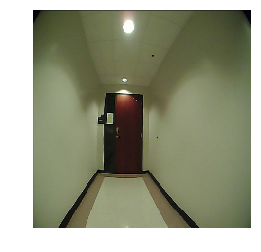

In [48]:
%matplotlib inline
idx = 200
print('WiFi\t\t', wifi_train[idx])
print('Mag\t\t', mag_train[idx])
print('XY\t\t', y_train[idx])
print('XY Class\t', y_cls_train[idx])
plt.axis('off')
plt.imshow(img_train[idx])
plt.show()

In [49]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [50]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.trainable = False

vgg.summary()
#images_test = preprocess_input(images_test)
#images_train = preprocess_input(images_train)

#features = model.predict(images_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [80]:
# define model inputs
wifi_input = Input(shape=(len(hall_localizer.profile),), dtype='float32')
mag_input = Input(shape=(1,), dtype='float32')
img_input = Input(shape=(224, 224, 3), dtype='float32')

wifi_branch = Dense(64, activation='relu')(wifi_input)

mag_branch = Dense(16, activation='relu')(mag_input)

img_branch = vgg(img_input)
img_branch = Flatten()(img_branch)

#merged = concatenate([wifi_branch, mag_branch, img_branch], axis=-1)
merged = concatenate([wifi_branch, mag_branch], axis=-1)

merged = Dense(16, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
#out = Dense(2, activation='linear')(merged)
out = Dense(len(class_dict), activation='softmax')(merged)

#model = Model([wifi_input, mag_input, img_input], out)
model = Model([wifi_input, mag_input], out)

#model.compile(optimizer='rmsprop', loss='mse')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 30)            0                                            
____________________________________________________________________________________________________
input_19 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_31 (Dense)                 (None, 64)            1984        input_18[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 16)            32          input_19[0][0]                   
___________________________________________________________________________________________

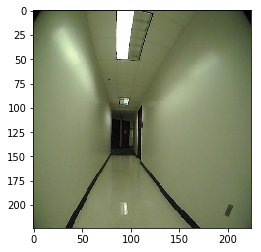

In [81]:
plt.imshow(img_train[4])

In [82]:
batch_size = 50
epochs = 1000
model_name = 'test_model'
if not os.path.exists('../models/' + model_name):
    os.makedirs('../models/' + model_name)

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint('../models/' + model_name + '/' + model_name + '.hdf5', monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]


In [83]:
train_data = [wifi_train, mag_train]
val_data = ([wifi_val, mag_val], y_cls_val)
test_data = [wifi_test, mag_test]


In [84]:
model.fit(train_data, y_cls_train, batch_size=batch_size, epochs=epochs, validation_data=val_data, callbacks=callbacks_list)
print(model.evaluate(test_data, y_cls_test, batch_size=batch_size))

Train on 1248 samples, validate on 156 samples
Epoch 1/1000
1248/1248 [==============================] - 0s - loss: 3.9315 - acc: 0.0248 - val_loss: 3.9098 - val_acc: 0.0321
Epoch 2/1000
1248/1248 [==============================] - 0s - loss: 3.8557 - acc: 0.0401 - val_loss: 3.8133 - val_acc: 0.0385
Epoch 3/1000
1248/1248 [==============================] - 0s - loss: 3.7195 - acc: 0.0425 - val_loss: 3.6476 - val_acc: 0.0256
Epoch 4/1000
1248/1248 [==============================] - 0s - loss: 3.5168 - acc: 0.0449 - val_loss: 3.4324 - val_acc: 0.0513
Epoch 5/1000
1248/1248 [==============================] - 0s - loss: 3.2936 - acc: 0.0785 - val_loss: 3.2105 - val_acc: 0.0769
Epoch 6/1000
1248/1248 [==============================] - 0s - loss: 3.0827 - acc: 0.0905 - val_loss: 3.0237 - val_acc: 0.1154
Epoch 7/1000
1248/1248 [==============================] - 0s - loss: 2.8948 - acc: 0.1194 - val_loss: 2.8482 - val_acc: 0.1346
Epoch 8/1000
1248/1248 [==============================] - 0s - l

1248/1248 [==============================] - 0s - loss: 1.9134 - acc: 0.3077 - val_loss: 1.9687 - val_acc: 0.2244
Epoch 27/1000
1248/1248 [==============================] - 0s - loss: 1.8856 - acc: 0.3301 - val_loss: 1.9108 - val_acc: 0.3333
Epoch 28/1000
1248/1248 [==============================] - 0s - loss: 1.8708 - acc: 0.3285 - val_loss: 1.8650 - val_acc: 0.3333
Epoch 29/1000
1248/1248 [==============================] - 0s - loss: 1.8433 - acc: 0.3317 - val_loss: 1.8647 - val_acc: 0.3590
Epoch 30/1000
1248/1248 [==============================] - 0s - loss: 1.8252 - acc: 0.3349 - val_loss: 1.8695 - val_acc: 0.3077
Epoch 31/1000
1248/1248 [==============================] - 0s - loss: 1.8045 - acc: 0.3421 - val_loss: 1.8453 - val_acc: 0.3077
Epoch 32/1000
1248/1248 [==============================] - 0s - loss: 1.7685 - acc: 0.3446 - val_loss: 1.7820 - val_acc: 0.3590
Epoch 33/1000
1248/1248 [==============================] - 0s - loss: 1.7603 - acc: 0.3446 - val_loss: 1.7851 - val_ac

1248/1248 [==============================] - 0s - loss: 1.4948 - acc: 0.4343 - val_loss: 1.6178 - val_acc: 0.3526
Epoch 56/1000
1248/1248 [==============================] - 0s - loss: 1.4836 - acc: 0.4215 - val_loss: 1.5745 - val_acc: 0.3526
Epoch 57/1000
1248/1248 [==============================] - 0s - loss: 1.4746 - acc: 0.4319 - val_loss: 1.5918 - val_acc: 0.3910
Epoch 58/1000
1248/1248 [==============================] - 0s - loss: 1.4640 - acc: 0.4391 - val_loss: 1.5458 - val_acc: 0.4038
Epoch 59/1000
1248/1248 [==============================] - 0s - loss: 1.4561 - acc: 0.4335 - val_loss: 1.5508 - val_acc: 0.3846
Epoch 60/1000
1248/1248 [==============================] - 0s - loss: 1.4512 - acc: 0.4423 - val_loss: 1.5344 - val_acc: 0.3654
Epoch 61/1000
1248/1248 [==============================] - 0s - loss: 1.4524 - acc: 0.4431 - val_loss: 1.5129 - val_acc: 0.3974
Epoch 62/1000
1248/1248 [==============================] - 0s - loss: 1.4482 - acc: 0.4415 - val_loss: 1.5549 - val_ac

1248/1248 [==============================] - 0s - loss: 1.3242 - acc: 0.4768 - val_loss: 1.4074 - val_acc: 0.4359
Epoch 86/1000
1248/1248 [==============================] - 0s - loss: 1.3304 - acc: 0.4800 - val_loss: 1.4382 - val_acc: 0.4551
Epoch 87/1000
1248/1248 [==============================] - 0s - loss: 1.3183 - acc: 0.4663 - val_loss: 1.4881 - val_acc: 0.4231
Epoch 88/1000
1248/1248 [==============================] - 0s - loss: 1.3219 - acc: 0.4880 - val_loss: 1.4432 - val_acc: 0.4038
Epoch 89/1000
1248/1248 [==============================] - 0s - loss: 1.3095 - acc: 0.4736 - val_loss: 1.4748 - val_acc: 0.4231
Epoch 90/1000
1248/1248 [==============================] - 0s - loss: 1.3090 - acc: 0.4776 - val_loss: 1.4496 - val_acc: 0.4103
Epoch 91/1000
 50/156 [========>.....................] - ETA: 0s[1.4566135207811992, 0.43589740838759983]


In [38]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    fill_mode='constant',
    horizontal_flip=False,
    vertical_flip=False)

train_datagen.fit(img_train)

val_datagen = train_datagen

for X_batch, y_batch in datagen.flow(images_train, y_cls_train):
    for i in range(0, 4):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

model.fit_generator(train_datagen.flow(img_train, y_cls_train, batch_size=batch_size), 
                    steps_per_epoch=len(img_train) / batch_size, epochs=epochs,
                    validation_data=val_datagen.flow(img_val, y_cls_val, batch_size=batch_size), 
                    validation_steps=len(img_val) / batch_size,
                    callbacks=callbacks_list)
print(model.evaluate(test_data, y_cls_test, batch_size=batch_size))

NameError: name 'datagen' is not defined

In [64]:
print(np.argmax(model.predict(wifi_test[3:4])))
print(np.argmax(y_cls_test[3:4]))

19
19


ValueError: Error when checking : expected input_12 to have 2 dimensions, but got array with shape (1, 224, 224, 3)

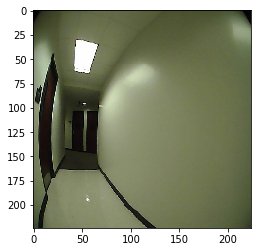

In [65]:
idx = 7
plt.imshow(img_test[idx])
prediction = model.predict(np.expand_dims(np.array(img_test[idx]), axis=0))
print(prediction)
print('Predicted Index: ', np.argmax(prediction))
print('Actual Index: ', np.argmax(y_cls_test[idx:idx+1]))

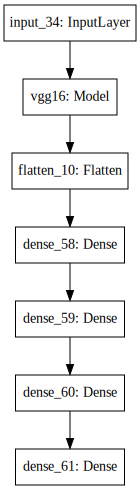

In [92]:
from keras.utils import plot_model
plot_model(model, to_file='./media/model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Visualize

In [89]:
def plot_predictions(model, figure_name, x_vals, y_vals, eval_range=.05):
    # generate color dictionary
    unique_collection_points = []
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    num_points = len(unique_collection_points)
 
    color_map_iter = iter(cm.rainbow(np.linspace(0, 1, num_points)))
    colors = {}
    for loc in y_vals:
        try:
            colors[tuple(loc)]
        except:
            colors[tuple(loc)] = next(color_map_iter)
            
    # plot points
    correct_points = 0
    ax = plt.gca()
    pred_set = model.predict(x_vals, verbose=0)
    for i, point in enumerate(pred_set):
        color = colors[tuple(y_vals[i])]
        plt.scatter(point[0], point[1], color=color)
        # compute the distance to the target
        x_diff = point[0] - y_vals[i,0]
        y_diff = point[1] - y_vals[i,1]
        dist = np.sqrt(np.square(x_diff) + np.square(y_diff))
        if dist < eval_range:
            correct_points += 1
    # plot acceptable range circles
    for item in colors:
        plt.scatter(float(item[0]), float(item[1]), color='black', marker='x')
        rect = patches.Circle((float(item[0]), float(item[1])),
                              radius=eval_range,linewidth=2,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
    plt.title('{} \nCorrect Predictions: {}/{} {:.2f}%'.format(figure_name, correct_points, len(pred_set), 
                                                  100*float(correct_points)/float(len(pred_set))))
    
    plt.savefig(figure_name)
    plt.show()
    

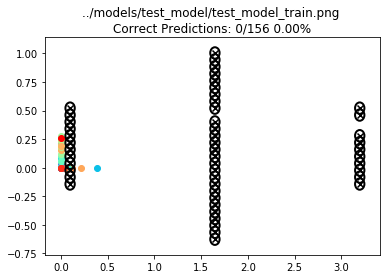

In [90]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_train.png', 
                 [wifi_test, mag_test], y_test)

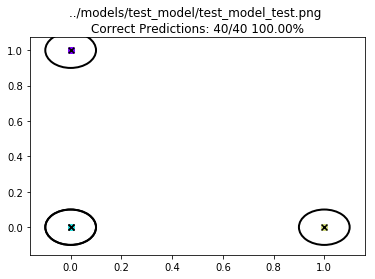

In [52]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_test.png', 
                 [img_test], y_cls_test)